<center><h1>DSCI 552 HW4</h1></center>
<br>
<center><font size="4">Time Series Classification</font></center>
<br />
<table align="center">
    <tbody>
    <tr><td>Name</td><td>Parth Patel</td></tr>
    <tr><td>USC ID</td><td>5228107917</td></tr>
     <tr><td>Github Username</td><td>parthpar-usc</td></tr>
    <tr><td>Email</td><td>parthpar@usc.edu</td></tr>
    </tbody>
</table>

## 1.Time Series Classification Part 1: Feature Creation/Extraction

#### (a)Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29. The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg_rss12, var_rss12, avg_rss13, var_rss13,vg_rss23, and ar_rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

#### Import required packages

In [1]:
! pip install bootstrapped
import pandas as pd
import glob
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score
import math
from tabulate import tabulate
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import numpy as np
import scipy.stats as st
from pathlib import Path
import os
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


#### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,2, and 3 in other folders as test data and other datasets as train data.

In [2]:
base_path = '../data/AReM'

train_data = []
test_data = []

def load_data(file_path, activity, test=False):
    try:
        df = pd.read_csv(file_path, skiprows=4)
    except pd.errors.ParserError:
        try:
            df = pd.read_csv(file_path, skiprows=4)
        except Exception as e:
            print(f"Failed to read {file_path} on second attempt: {e}")
            return
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return
    
    if test:
        test_data.append({'activity': activity, 'filename': os.path.basename(file_path), 'data': df})
    else:
        train_data.append({'activity': activity, 'filename': os.path.basename(file_path), 'data': df})

for activity in os.listdir(base_path):
    activity_path = os.path.join(base_path, activity)
    if os.path.isdir(activity_path):
        filenames = sorted(os.listdir(activity_path))
        
        if activity in ['bending1', 'bending2']:
            for filename in filenames[:2]:
                file_path = os.path.join(activity_path, filename)
                load_data(file_path, activity, test=True)
            for filename in filenames[2:]:
                file_path = os.path.join(activity_path, filename)
                load_data(file_path, activity)
                
        else:
            for filename in filenames[:3]:
                file_path = os.path.join(activity_path, filename)
                load_data(file_path, activity, test=True)
            for filename in filenames[3:]:
                file_path = os.path.join(activity_path, filename)
                load_data(file_path, activity)


def convert_and_flatten_data(data_list):
    flattened_data = []
    for item in data_list:
        df = item['data']
        for column in df.columns:
            try:
                df[column] = pd.to_numeric(df[column], errors='coerce')
            except Exception as e:
                print(f"Error converting column {column} to numeric: {e}")
                continue 
        
        numeric_df = df.select_dtypes(include=['number']) 
        mean_values = numeric_df.mean().to_dict()
        
        mean_values['activity'] = item['activity']
        mean_values['filename'] = item['filename']
        flattened_data.append(mean_values)
    
    return pd.DataFrame(flattened_data)

train_df = convert_and_flatten_data(train_data)
test_df = convert_and_flatten_data(test_data)
                                                                                                                                        
len(test_data)

full_data=pd.concat([train_df,test_df], ignore_index = True)
full_data



# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0           59875.0  43.954500   0.426250  22.122354   0.497312  35.588458   
1           59875.0  42.179812   0.696042  22.183625   0.989917  33.493917   
2           59875.0  41.678063   0.535979  19.006563   0.841875  29.857083   
3           59875.0  43.454958   0.378083  15.793333   0.849354  23.034792   
4           59875.0  43.969125   0.413125  15.868021   0.666354  22.103750   
..              ...        ...        ...        ...        ...        ...   
83          59875.0  27.716375   0.363687   6.078104   0.870042   8.337021   
84          59875.0  48.004167   0.007167   4.900563   0.397312   7.624896   
85          59875.0  37.177042   2.374208  16.531083   2.910604  19.607250   
86          59875.0  36.819521   2.600146  15.302625   2.937021  17.296271   
87          59875.0  36.541667   2.847958  16.156063   3.055458  17.062625   

    var_rss23  activity       filename  
0    0.493292  bending1   dataset3.csv  
1    0.613521  bending1   dataset4.csv  
2    0.383292  bending1   dataset5.csv  
3    0.679646  bending1   dataset6.csv  
4    0.555312  bending1   dataset7.csv  
..        ...       ...            ...  
83   0.735396     lying  dataset10.csv  
84   0.641229     lying  dataset11.csv  
85   2.921729   cycling   dataset1.csv  
86   2.887563   cycling  dataset10.csv  
87   3.225458   cycling  dataset11.csv  

[88 rows x 9 columns]

In [3]:
dataPath = '../data/AReM/'
dir1 = ['bending1', 'bending2']
dir2 = ['cycling', 'lying', 'sitting', 'standing', 'walking']
trainCSVs, testCSVs, allCSVs = [], [], []
curr=[]

for d in dir1:
    for filename in os.listdir(dataPath+d):
        curr.append(dataPath+d+"/"+filename)
        if filename[-6:-4] in ('t1', 't2'):
            testCSVs.append(dataPath+d+"/"+filename)
        else:
            trainCSVs.append(dataPath+d+"/"+filename)
for d in dir2:
    for filename in os.listdir(dataPath+d):
        curr.append(dataPath+d+"/"+filename)
        if filename[-6:-4] in ('t1', 't2' , 't3'):
            testCSVs.append(dataPath+d+"/"+filename)
        else:
            trainCSVs.append(dataPath+d+"/"+filename)
curr.sort()
allCSVs.append(curr)

trainCSVs

['../data/AReM/bending1/dataset7.csv',
 '../data/AReM/bending1/dataset6.csv',
 '../data/AReM/bending1/dataset4.csv',
 '../data/AReM/bending1/dataset5.csv',
 '../data/AReM/bending1/dataset3.csv',
 '../data/AReM/bending2/dataset6.csv',
 '../data/AReM/bending2/dataset4.csv',
 '../data/AReM/bending2/dataset5.csv',
 '../data/AReM/bending2/dataset3.csv',
 '../data/AReM/cycling/dataset7.csv',
 '../data/AReM/cycling/dataset6.csv',
 '../data/AReM/cycling/dataset4.csv',
 '../data/AReM/cycling/dataset5.csv',
 '../data/AReM/cycling/dataset10.csv',
 '../data/AReM/cycling/dataset11.csv',
 '../data/AReM/cycling/dataset13.csv',
 '../data/AReM/cycling/dataset12.csv',
 '../data/AReM/cycling/dataset15.csv',
 '../data/AReM/cycling/dataset14.csv',
 '../data/AReM/cycling/dataset8.csv',
 '../data/AReM/cycling/dataset9.csv',
 '../data/AReM/lying/dataset7.csv',
 '../data/AReM/lying/dataset6.csv',
 '../data/AReM/lying/dataset4.csv',
 '../data/AReM/lying/dataset5.csv',
 '../data/AReM/lying/dataset10.csv',
 '../d

### (c) Feature Extraction
### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features

#### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

The features that are commonly used for time series classification are as follows:

Min: It is the minimum value in a dataset.

Max: It is the maximum value in a dataset.

Mean: It is the average of the values in a dataset.

Median: It is the middle value which divides the upper half and lower half of the dataset.

Standard Deviation: It is a measure of how dispersed the data is in relation to the mean.

1st Quartile: It the value under which 25% if the data points are found in a dataset.

3rd Quartile: It the value under which 75% if the data points are found in a dataset.

Interquartile Range: It is the range between 25% and 75%, where the middle 50% of the data points lie.

Range: It is the difference between the min and max values of a dataset.

Variance: It is mean squared difference between each data point and the centre of the distribution measured by the mean.

#### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [4]:
def extract_features(series):
    return [
        series.min(),
        series.max(),
        series.mean(),
        series.median(),
        series.std(),
        series.quantile(0.25),
        series.quantile(0.75)
    ]

def load_data(file_path):
    try:
        df = pd.read_csv(file_path, skiprows=5, header=None)
        df = df.drop(df.columns[0], axis=1)
        return df
    except pd.errors.ParserError:
        print(f"Parser error when reading {file_path}")
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
    return None

feature_vectors = []

base_path = '../data/AReM'

instance_counter = 1

for activity in os.listdir(base_path):
    activity_path = os.path.join(base_path, activity)
    
    if os.path.isdir(activity_path):
        filenames = sorted(os.listdir(activity_path)) 
        
        for filename in filenames:
            file_path = os.path.join(activity_path, filename)
            df = load_data(file_path)
            if df is not None:
                features = [instance_counter]
                for column in df.columns:
                    features.extend(extract_features(df[column]))
                
                feature_vectors.append(features)
                instance_counter += 1

features_df = pd.DataFrame(feature_vectors, columns=[
    'Instance', 'min1', 'max1', 'mean1', 'median1', 'std1', '1st_quart1', '3rd_quart1',
    'min2', 'max2', 'mean2', 'median2', 'std2', '1st_quart2', '3rd_quart2',
    'min3', 'max3', 'mean3', 'median3', 'std3', '1st_quart3', '3rd_quart3',
    'min4', 'max4', 'mean4', 'median4', 'std4', '1st_quart4', '3rd_quart4',
    'min5', 'max5', 'mean5', 'median5', 'std5', '1st_quart5', '3rd_quart5',
    'min6', 'max6', 'mean6', 'median6', 'std6', '1st_quart6', '3rd_quart6'
])

features_df


Instance   min1   max1      mean1  median1      std1  1st_quart1  \
0          1  37.25  45.00  40.624792    40.50  1.476967       39.25   
1          2  38.00  45.67  42.812812    42.50  1.435550       42.00   
2          3  35.00  47.40  43.954500    44.33  1.558835       43.00   
3          4  33.00  47.75  42.179812    43.50  3.670666       39.15   
4          5  33.00  45.75  41.678063    41.75  2.243490       41.33   
..       ...    ...    ...        ...      ...       ...         ...   
83        84  26.50  44.33  36.687292    36.00  3.529404       34.25   
84        85  25.33  45.00  37.114313    36.25  3.710385       34.50   
85        86  26.75  44.75  36.863375    36.33  3.555787       34.50   
86        87  26.25  44.25  36.957458    36.29  3.434863       34.50   
87        88  27.75  44.67  37.144833    36.33  3.758904       34.00   

    3rd_quart1  min2   max2  ...      std5  1st_quart5  3rd_quart5  min6  \
0      42.0000   0.0   1.30  ...  2.188449     33.0000       36.00   0.0   
1      43.6700   0.0   1.22  ...  1.995255     32.0000       34.50   0.0   
2      45.0000   0.0   1.70  ...  1.999604     35.3625       36.50   0.0   
3      45.0000   0.0   3.00  ...  3.849448     30.4575       36.33   0.0   
4      42.7500   0.0   2.83  ...  2.411026     28.4575       31.25   0.0   
..         ...   ...    ...  ...       ...         ...         ...   ...   
83     39.3725   0.0  12.89  ...  2.978238     14.6700       18.50   0.0   
84     40.2500   0.0  10.84  ...  2.847876     14.7500       18.50   0.0   
85     39.7500   0.0  11.68  ...  2.655906     15.0000       18.67   0.0   
86     40.2500   0.0   8.64  ...  2.851673     14.0000       18.25   0.0   
87     40.5000   0.0  10.76  ...  2.689291     15.0000       18.75   0.0   

    max6     mean6  median6      std6  1st_quart6  3rd_quart6  
0   1.92  0.570583    0.430  0.582915      0.0000      1.3000  
1   3.11  0.571083    0.430  0.601010      0.0000      1.3000  
2   1.79  0.493292    0.430  0.513506      0.0000      0.9400  
3   2.18  0.613521    0.500  0.524317      0.0000      1.0000  
4   1.79  0.383292    0.430  0.389164      0.0000      0.5000  
..   ...       ...      ...       ...         ...         ...  
83  8.19  3.073313    2.690  1.629675      1.9125      4.0875  
84  9.50  3.076354    2.770  1.824534      1.7000      4.0375  
85  8.81  2.773313    2.590  1.569919      1.6400      3.6325  
86  8.34  2.934625    2.525  1.631380      1.6600      4.0300  
87  8.75  2.822437    2.590  1.637183      1.5800      3.7400  

[88 rows x 43 columns]

### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature

In [5]:

table_headers = ["Feature", "Std Dev", "Low", "High"]
table_data = []

def bootstrap_std_confidence_interval(feature_data, n_resamples=1000, conf_level=0.9):
    bootstrapped_stds = []
    for _ in range(n_resamples):
        sample = resample(feature_data)
        bootstrapped_stds.append(np.std(sample, ddof=1)) 
    alpha = 1 - conf_level
    lower_percentile = alpha / 2.0 * 100
    upper_percentile = (1 - alpha / 2.0) * 100
    confidence_low = np.percentile(bootstrapped_stds, lower_percentile)
    confidence_high = np.percentile(bootstrapped_stds, upper_percentile)
    return np.std(feature_data, ddof=1), confidence_low, confidence_high  

for col in features_df.columns:
    feature_data = features_df[col]
    std_dev, low, high = bootstrap_std_confidence_interval(feature_data)  
    table_data.append([col, std_dev, low, high])  

results_df = pd.DataFrame(table_data, columns=table_headers)

results_df


Feature    Std Dev        Low       High
0     Instance  25.547342  23.389840  27.299540
1         min1   9.624011   8.298413  10.823656
2         max1   4.207745   3.052958   5.045200
3        mean1   5.276431   4.653142   5.825071
4      median1   5.386624   4.737180   5.928177
5         std1   1.771282   1.571377   1.944683
6   1st_quart1   6.127846   5.562543   6.642823
7   3rd_quart1   5.031028   4.197472   5.758802
8         min2   0.000000   0.000000   0.000000
9         max2   5.059656   4.616386   5.383593
10       mean2   1.577908   1.396232   1.711708
11     median2   1.413545   1.245028   1.550274
12        std2   0.885875   0.800341   0.941383
13  1st_quart2   0.948434   0.818786   1.036321
14  3rd_quart2   2.131337   1.890556   2.307239
15        min3   2.954516   2.758570   3.115751
16        max3   4.819848   4.100074   5.374854
17       mean3   3.976754   3.361727   4.449940
18     median3   4.009687   3.428781   4.564617
19        std3   0.952011   0.764829   1.125254
20  1st_quart3   4.184148   3.569806   4.691106
21  3rd_quart3   4.153451   3.526566   4.685746
22        min4   0.000000   0.000000   0.000000
23        max4   2.181809   1.963851   2.354228
24       mean4   1.168268   1.078534   1.223274
25     median4   1.148591   1.063572   1.205857
26        std4   0.458612   0.423269   0.487633
27  1st_quart4   0.844919   0.776495   0.890668
28  3rd_quart4   1.555235   1.441079   1.628189
29        min5   6.121205   4.343360   7.473071
30        max5   5.773355   4.758861   6.617091
31       mean5   5.704025   4.443076   6.798064
32     median5   5.844368   4.476547   6.873491
33        std5   1.012358   0.817803   1.201620
34  1st_quart5   6.122142   4.813336   7.186490
35  3rd_quart5   5.563553   4.394078   6.577617
36        min6   0.046101   0.000000   0.078915
37        max6   2.533515   2.283768   2.765054
38       mean6   1.157222   1.063301   1.218737
39     median6   1.089858   0.994322   1.153088
40        std6   0.516968   0.477244   0.543159
41  1st_quart6   0.761542   0.700329   0.810808
42  3rd_quart6   1.526871   1.409196   1.601449

### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

### Mean (meanX): Highlights the average behavior of the time series, revealing the central trend across an observation period.

### Standard Deviation (stdX): Indicates the level of fluctuation around the mean, with higher values suggesting more erratic behavior and lower values pointing to stability.

### Maximum (maxX) / Minimum (minX): Identifies extreme peaks and troughs, crucial for spotting exceptional events and understanding the range of variation.

### 2. I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. $ Y = β0 +β1X +β2X^2 +β3X^3 +ε $.
### (a) Suppose that the true relationship between X and Y is linear, i.e. $Y = β0 + β1X + ε$. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

### If the true relationship is linear, the training RSS for the cubic regression will likely be lower or the same as for the linear regression due to its flexibility to fit the data more closely, potentially including noise.

### (b) Answer (a) using test rather than training RSS.

### For the test RSS, the linear regression should perform better if the true relationship is linear, as the cubic regression may overfit the training data and thus perform worse on unseen test data.

### (c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

### If the true relationship between $X$ and $Y$ is not linear, then the linear regression model will not be the correct specification, and the cubic regression may capture the relationship better if the true form is closer to cubic. In this case, we would expect the training RSS for the cubic regression to be lower than for the linear regression, as the cubic model can adjust to more complex relationships in the data.

### (d) Answer (c) using test rather than training RSS.

### For the test RSS, if the true relationship is non-linear, the cubic regression is expected to have a lower test RSS, indicating better generalization and fit to the true underlying pattern.

# Homework 4
## 2. Binary and Multiclass Clsassification
## (a)  Binary Classification Using Logistic Regression


## i. Plots

In [6]:
finalList = []
cols = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
columnNames = ['min1', 'max1', 'mean1', 'median1', 'std_dev1', '1st_quart1', '3rd_quart1',
               'min2', 'max2', 'mean2', 'median2', 'std_dev2', '1st_quart2', '3rd_quart2',
               'min3', 'max3', 'mean3', 'median3', 'std_dev3', '1st_quart3', '3rd_quart3',
               'min4', 'max4', 'mean4', 'median4', 'std_dev4', '1st_quart4', '3rd_quart4',
               'min5', 'max5', 'mean5', 'median5', 'std_dev5', '1st_quart5', '3rd_quart5',
               'min6', 'max6', 'mean6', 'median6', 'std_dev6', '1st_quart6', '3rd_quart6', 'Activity']

for csv in trainCSVs:
    dataFrame = pd.read_csv(csv, skiprows=4, usecols=cols)
    desc = dataFrame.describe().transpose().iloc[:, [3, 7, 1, 5, 2, 4, 6]].values.flatten().tolist()
    activity = 'bending' if csv.split("/")[-2] in ("bending1", "bending2") else 'non-bending'
    desc.append(activity)
    finalList.append(desc)


In [7]:
requiredData = pd.DataFrame(finalList, columns = columnNames)
requiredData

min1   max1      mean1  median1  std_dev1  1st_quart1  3rd_quart1  min2  \
0   36.25  48.00  43.969125   44.500  1.618364       43.31       44.67   0.0   
1   37.00  48.00  43.454958   43.250  1.386098       42.50       45.00   0.0   
2   33.00  47.75  42.179812   43.500  3.670666       39.15       45.00   0.0   
3   33.00  45.75  41.678063   41.750  2.243490       41.33       42.75   0.0   
4   35.00  47.40  43.954500   44.330  1.558835       43.00       45.00   0.0   
..    ...    ...        ...      ...       ...         ...         ...   ...   
64  19.75  45.50  34.322750   35.250  4.752477       31.00       38.00   0.0   
65  19.25  44.00  34.473188   35.000  4.796705       31.25       38.00   0.0   
66  23.50  46.25  34.873229   35.250  4.531720       31.75       38.25   0.0   
67  18.33  45.75  34.599875   35.125  4.731790       31.50       38.00   0.0   
68  15.50  43.67  34.225875   34.750  4.441798       31.25       37.25   0.0   

     max2     mean2  ...  1st_quart5  3rd_quart5  min6  max6     mean6  \
0    1.50  0.413125  ...     20.5000       23.75  0.00  2.96  0.555312   
1    1.58  0.378083  ...     22.2500       24.00  0.00  5.26  0.679646   
2    3.00  0.696042  ...     30.4575       36.33  0.00  2.18  0.613521   
3    2.83  0.535979  ...     28.4575       31.25  0.00  1.79  0.383292   
4    1.70  0.426250  ...     35.3625       36.50  0.00  1.79  0.493292   
..    ...       ...  ...         ...         ...   ...   ...       ...   
64  13.47  4.456333  ...     13.5000       17.75  0.00  9.67  3.432563   
65  13.86  4.359312  ...     13.7300       17.75  0.43  9.00  3.340458   
66  14.82  4.380583  ...     13.7500       18.00  0.00  9.51  3.424646   
67  15.37  4.398833  ...     14.0000       18.25  0.00  8.86  3.289542   
68  17.24  4.354500  ...     14.3300       18.25  0.00  9.42  3.479542   

    median6  std_dev6  1st_quart6  3rd_quart6     Activity  
0     0.490  0.487826      0.0000      0.8300      bending  
1     0.500  0.622534      0.4300      0.8700      bending  
2     0.500  0.524317      0.0000      1.0000      bending  
3     0.430  0.389164      0.0000      0.5000      bending  
4     0.430  0.513506      0.0000      0.9400      bending  
..      ...       ...         ...         ...          ...  
64    3.200  1.732727      2.1575      4.5650  non-bending  
65    3.090  1.699114      2.1200      4.3750  non-bending  
66    3.270  1.690960      2.1700      4.5000  non-bending  
67    3.015  1.680170      2.1200      4.2600  non-bending  
68    3.270  1.761146      2.2400      4.5375  non-bending  

[69 rows x 43 columns]

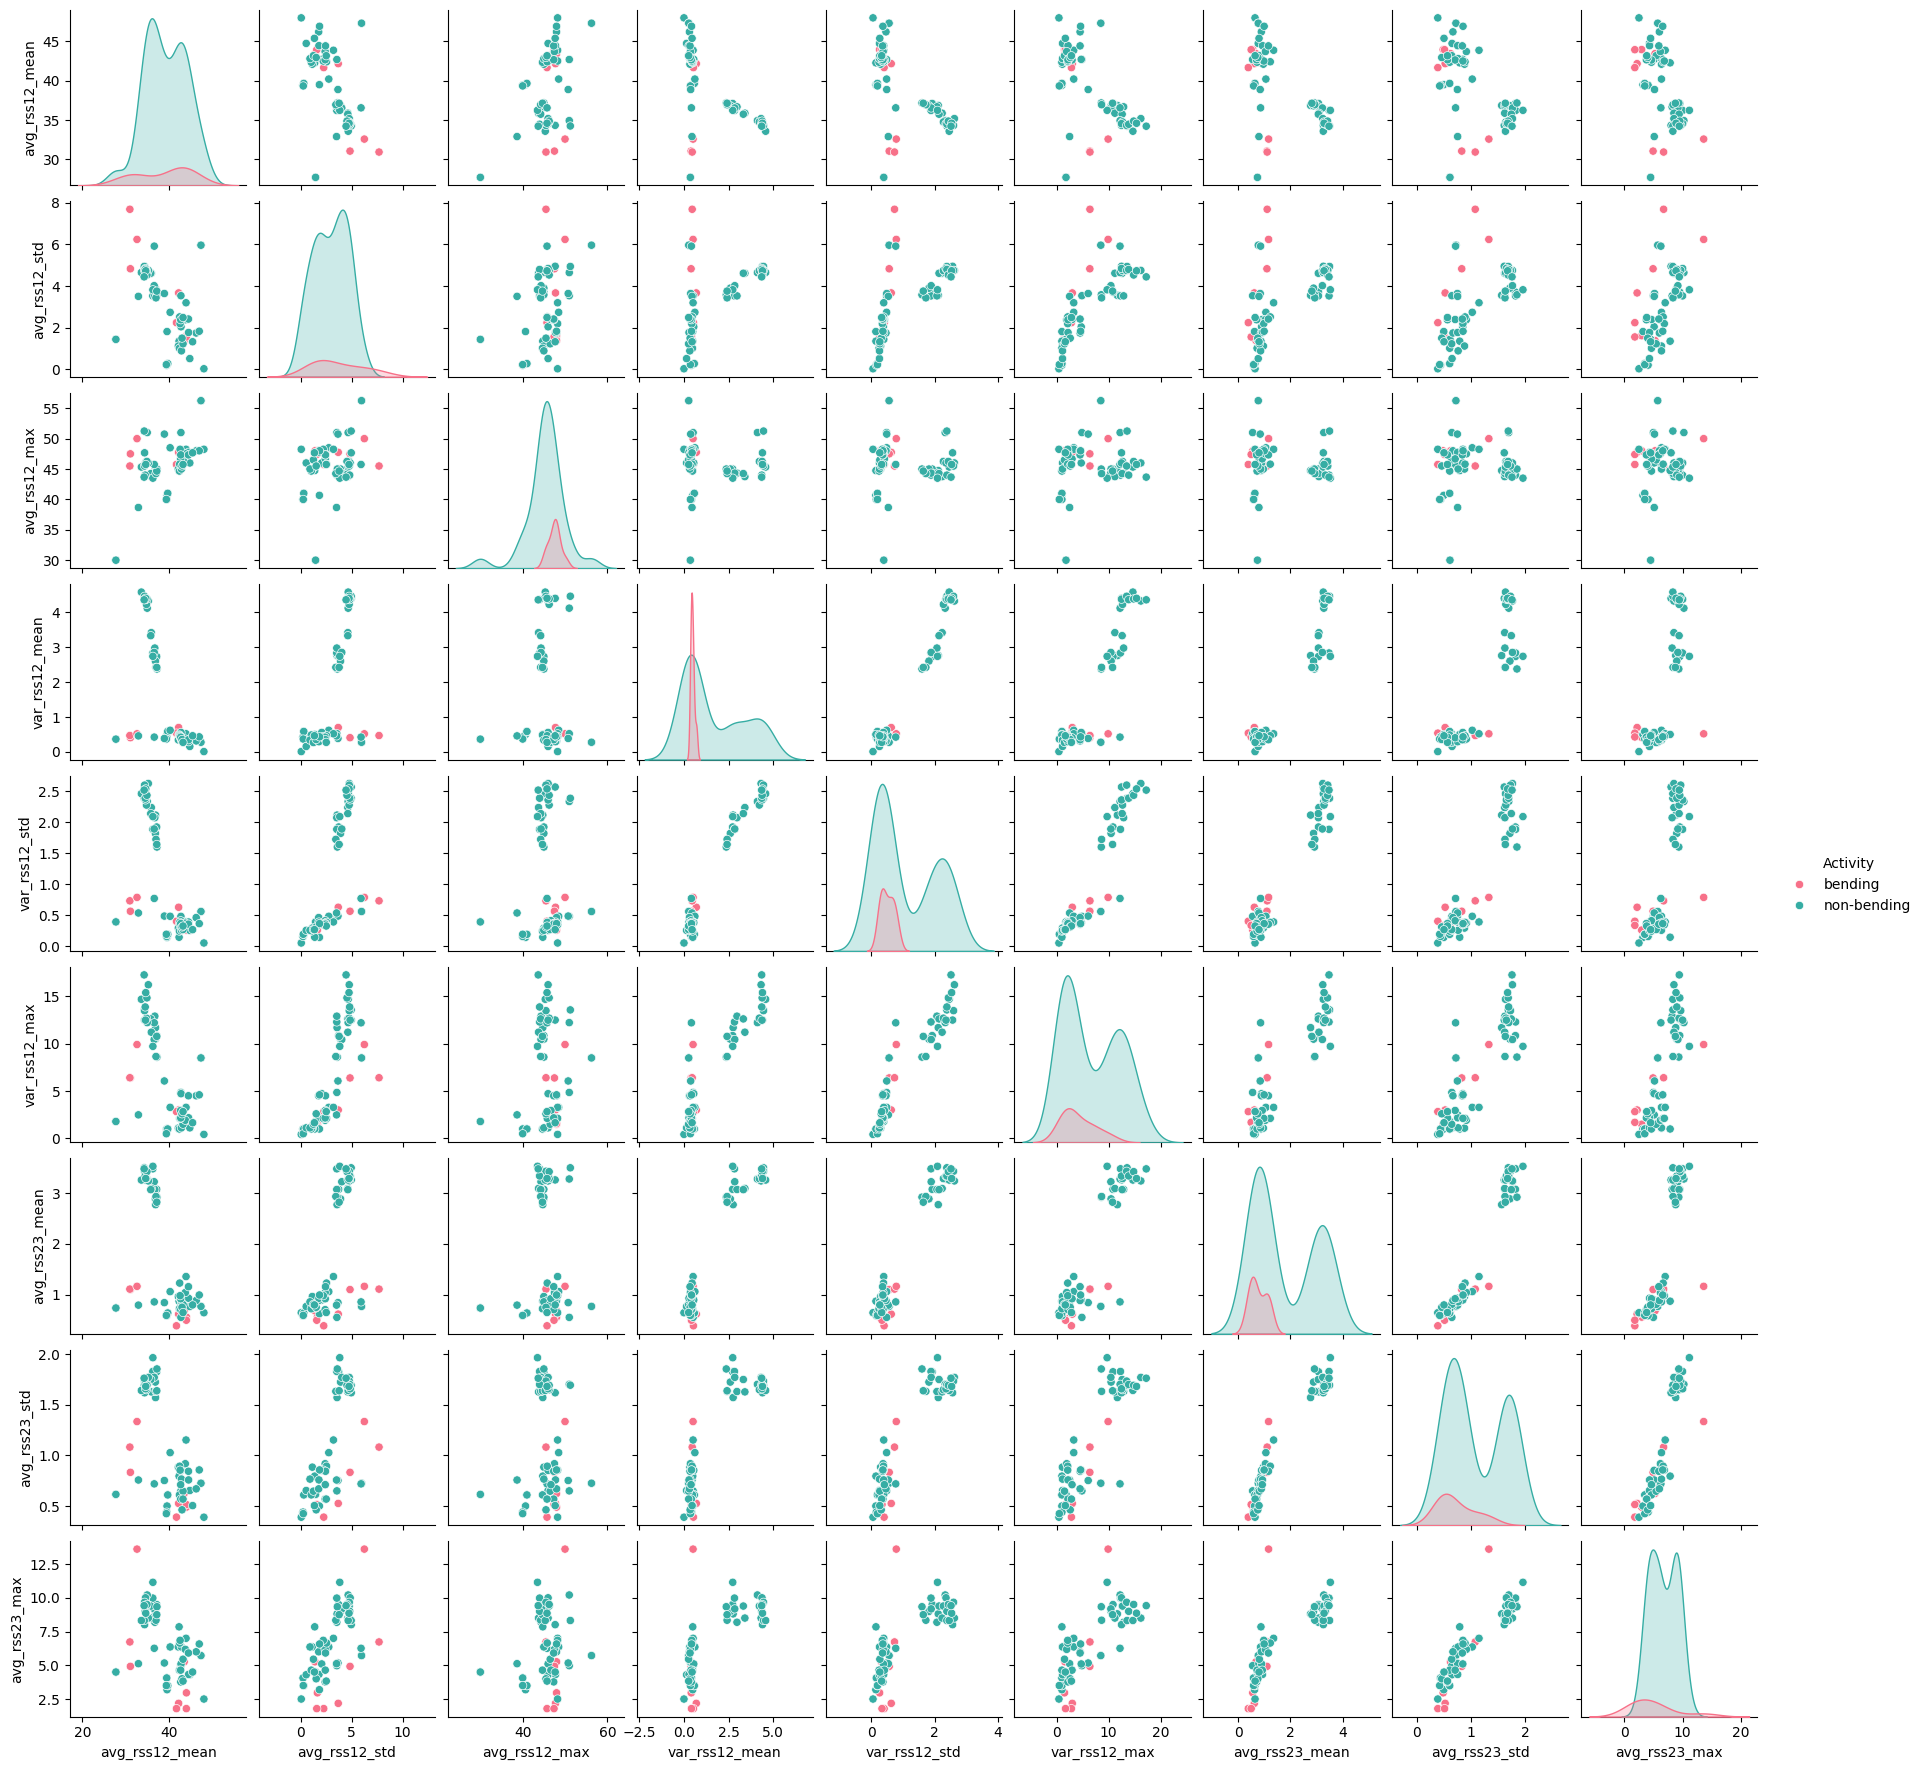

In [8]:
features = ['mean1', 'std_dev1', 'max1', 'mean2', 'std_dev2', 'max2', 'mean6', 'std_dev6', 'max6', 'Activity']
names = ['avg_rss12_mean', 'avg_rss12_std', 'avg_rss12_max', 'var_rss12_mean', 'var_rss12_std', 'var_rss12_max', 'avg_rss23_mean', 'avg_rss23_std', 'avg_rss23_max', 'Activity']

rename_dict = {features[i]: names[i] for i in range(len(features))}

selectedData = requiredData[features].rename(columns=rename_dict)

# Plot using seaborn
sns.pairplot(selectedData, hue='Activity', height=2, palette='husl')

## (a) ii. Splitted Plots

In [9]:
finalData = []
colNames = ['index', 'new_avg_rss12', 'new_var_rss12', 'new_avg_rss13', 'new_var_rss13', 'new_avg_rss23', 'new_var_rss23']

for csv in trainCSVs:
    dataFrame = pd.read_csv(csv, skiprows=4, on_bad_lines='skip')
    dataFrame1 = dataFrame.iloc[:240, 1:]
    dataFrame2 = dataFrame.iloc[240:, 1:].reset_index(drop=True)
    dataFrame2.columns = colNames[1:]  
    res = pd.concat([dataFrame1, dataFrame2], axis=1)
    
   
    desc = res.describe().transpose().iloc[:, [1, 2, 5]]  
    
    stats = desc.values.flatten().tolist()
    
 
    folder_name = csv.split("/")[-2]
    activity_class = 'bending' if folder_name in ('bending1', 'bending2') else 'non-bending'
    stats.append(activity_class)
    
    finalData.append(stats)


In [10]:
newCols = ['mean1', 'std_dev1','max1', 'mean2', 'std_dev2','max2','mean3', 'std_dev3','max3', 
           'mean4', 'std_dev4','max4', 'mean5','std_dev5','max5','mean6', 'std_dev6','max6', 
           'mean7', 'std_dev7','max7', 'mean8', 'std_dev8','max8', 'mean9', 'std_dev9','max9',
           'mean10', 'std_dev10','max10', 'mean11', 'std_dev11','max11', 'mean12', 'std_dev12','max12',
           'Activity']

requiredData = pd.DataFrame(finalData, columns = newCols)
requiredData

mean1  std_dev1    max1     mean2  std_dev2   max2      mean3  \
0   43.486208  1.281976  43.710  0.378667  0.284434  0.470  16.397250   
1   44.117042  1.359836  45.000  0.250042  0.314099  0.000  17.744167   
2   43.278875  3.473355  45.000  0.673292  0.634285  0.485  23.141250   
3   41.621208  3.118644  42.330  0.623083  0.489595  0.500  19.081458   
4   44.057167  1.556971  44.500  0.381042  0.329540  0.470  23.096792   
..        ...       ...     ...       ...       ...    ...        ...   
64  34.036750  4.872880  34.415  4.778292  2.762730  4.030  15.177083   
65  34.916792  4.634209  35.375  4.262333  2.396878  3.850  15.335250   
66  34.920792  4.272282  35.330  4.177958  2.341763  3.865  15.515875   
67  34.836458  4.869092  35.750  4.257750  2.512633  3.770  15.181958   
68  34.329333  4.549837  34.710  4.315917  2.470266  3.880  15.674167   

    std_dev3    max3     mean4  ...    mean10  std_dev10  max10     mean11  \
0   3.469237  16.875  0.662958  ...  0.669750   0.744611   0.47  21.882042   
1   4.010149  18.000  1.123000  ...  0.575708   0.730490   0.43  22.850875   
2   3.123258  23.750  0.808042  ...  1.171792   1.079233   0.87  30.965708   
3   5.102939  19.500  1.115083  ...  0.568667   0.456292   0.47  29.635833   
4   2.410625  24.000  0.493458  ...  0.501167   0.599386   0.43  34.883375   
..       ...     ...       ...  ...       ...        ...    ...        ...   
64  2.755151  15.250  3.394083  ...  3.160375   1.479333   2.95  15.520375   
65  2.881151  15.330  3.247792  ...  3.128750   1.565480   2.99  15.640917   
66  2.844735  15.500  3.235125  ...  3.176250   1.483199   2.95  15.939417   
67  2.981010  15.000  3.131417  ...  3.159583   1.652816   3.00  15.996875   
68  2.845277  15.670  3.366667  ...  3.364083   1.727270   3.02  16.021917   

    std_dev11   max11    mean12  std_dev12  max12     Activity  
0    1.929494  21.750  0.585750   0.487918  0.500      bending  
1    1.881721  23.250  0.543875   0.473445  0.500      bending  
2    3.760118  30.415  0.586083   0.491873  0.470      bending  
3    2.062647  29.750  0.347500   0.363144  0.430      bending  
4    2.298693  36.000  0.388333   0.478528  0.000      bending  
..        ...     ...       ...        ...    ...          ...  
64   3.162332  15.750  3.321417   1.758379  3.155  non-bending  
65   3.247042  16.000  3.241000   1.657578  3.060  non-bending  
66   3.163566  16.000  3.418667   1.598536  3.350  non-bending  
67   2.882455  16.000  3.409458   1.707089  3.110  non-bending  
68   2.967504  16.000  3.577833   1.794112  3.290  non-bending  

[69 rows x 37 columns]

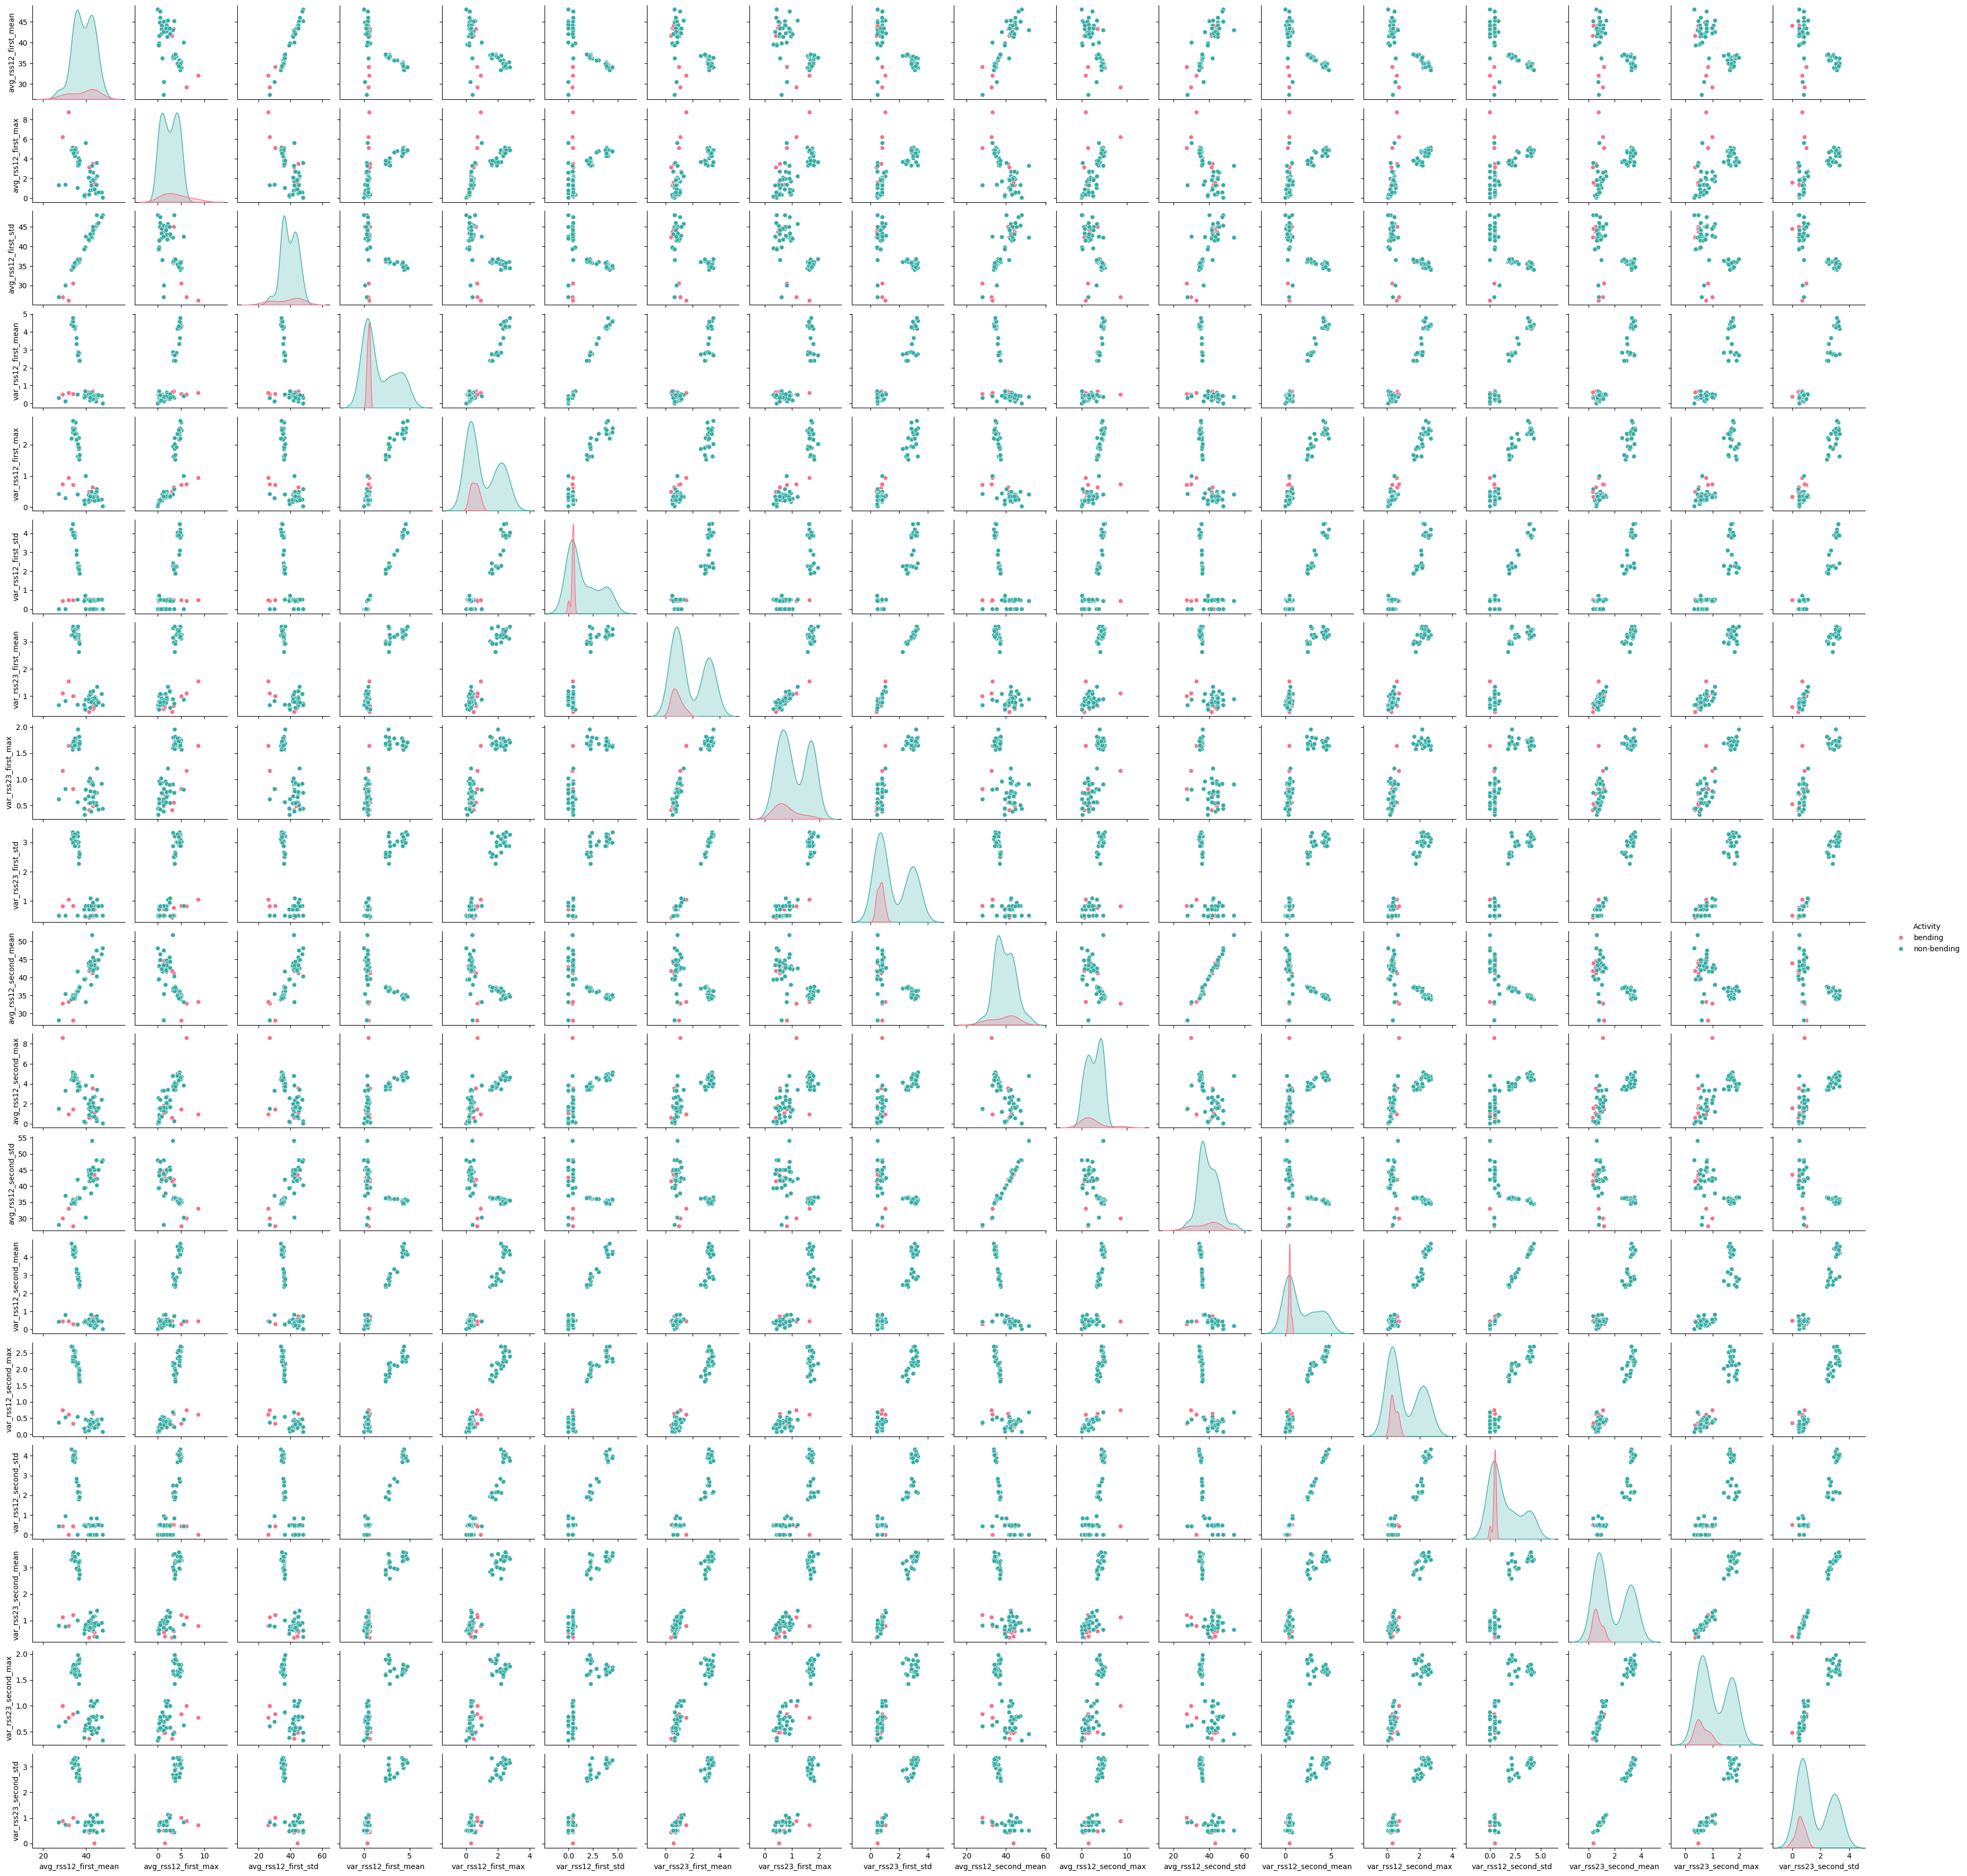

In [11]:
features = ['mean', 'std_dev', 'max']
suffixes = ['_first_', '_second_']
prefixes = ['avg_rss12', 'var_rss12', 'var_rss23']


colNames = [f"{prefix}{suffix}{feature}" 
            for prefix in prefixes 
            for suffix in suffixes 
            for feature in ['mean',  'std','max']]


selected_indices = [1, 2, 6, 7, 8, 12]
l = [f"{feature}{p}" for p in selected_indices for feature in features]
l.append('Activity')  


selectedData = requiredData.loc[:, l]

names = ['avg_rss12_first_mean', 'avg_rss12_first_max', 'avg_rss12_first_std', 'var_rss12_first_mean', 'var_rss12_first_max', 'var_rss12_first_std', 'var_rss23_first_mean', 'var_rss23_first_max', 'var_rss23_first_std', 'avg_rss12_second_mean', 'avg_rss12_second_max', 'avg_rss12_second_std', 'var_rss12_second_mean', 'var_rss12_second_max', 'var_rss12_second_std', 'var_rss23_second_mean', 'var_rss23_second_max', 'var_rss23_second_std']
names_mapping = {original: new for original, new in zip(l[:-1], names)}

selectedData.rename(columns=names_mapping, inplace=True)

sns.pairplot(selectedData, hue='Activity', height=2, palette='husl')



## By splitting the data we are able to create more samples and hence, we have more features to analyze. It also has led to sligthly different distribution of data, nothing major.

## (a) iii Time Series Segments


In [12]:
def breakTimeSeriesForBinaryData(filesList, n):
    finalColumns, finalData = [], []
    
    split = 480 // n
    
    for f in range(1, (n * 6) + 1):
        finalColumns.extend(['mean' + str(f), 'max' + str(f), 'std_dev' + str(f)])
    finalColumns.append('Activity')
    
    for csv in filesList:
        dataFrame = pd.read_csv(csv, skiprows=4, on_bad_lines='skip')
        segments = []
        
        for frameNo in range(n):
            start_idx = frameNo * split
            end_idx = start_idx + split
            segment = dataFrame.iloc[start_idx:end_idx, 1:].reset_index(drop=True)
            colNames = [f'{var}_{frameNo + 1}' for var in ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']]
            segment.columns = colNames
            segments.append(segment)
        
        allFrames = pd.concat(segments, axis=1)
        

        desc = allFrames.describe().transpose().iloc[:, [1, 5, 2]]
        stats = desc.values.flatten().tolist()
        
      
        activity_class = 1 if 'bending' in csv.split("/")[-2] else 0
        stats.append(activity_class)
        
        finalData.append(stats)
    
   
    requiredData = pd.DataFrame(finalData, columns=finalColumns)
    return requiredData


In [13]:
def evaluate_model_with_segments(n_segments, trainCSVs):
    trainData = breakTimeSeriesForBinaryData(trainCSVs, n_segments)
    trainData.dropna(inplace=True)
    xTrain = trainData.iloc[:, :-1]
    yTrain = trainData['Activity']

    logRegModel = LogisticRegression(penalty='none', max_iter=5000)
    rfecv = RFECV(estimator=logRegModel, cv=StratifiedKFold(5), scoring='accuracy')
    rfecv.fit(xTrain, yTrain)

    scores = {
        'n_features': rfecv.n_features_,
        'max_scores': [np.max(rfecv.cv_results_[f"split{i}_test_score"]) for i in range(5)],
        'mean_score': np.max(rfecv.cv_results_['mean_test_score'])
    }
    
    print(f'Optimal number of features for {n_segments} segments: {scores["n_features"]}')
    for i, score in enumerate(scores['max_scores'], start=1):
        print(f'Maximum cross-validation score for fold {i} is: {score}')
    print(f'Maximum average cross-validation score: {scores["mean_score"]}')
    print(" ")
    
    return scores

results = {
    'segments': [],
    'pFeats': [],
    'score1': [],
    'score2': [],
    'score3': [],
    'score4': [],
    'score5': [],
    'meanscore': []
}

for i in range(1, 21):
    scores = evaluate_model_with_segments(i, trainCSVs)
    
    results['segments'].append(i)
    results['pFeats'].append(scores['n_features'])
    results['score1'].append(scores['max_scores'][0])
    results['score2'].append(scores['max_scores'][1])
    results['score3'].append(scores['max_scores'][2])
    results['score4'].append(scores['max_scores'][3])
    results['score5'].append(scores['max_scores'][4])
    results['meanscore'].append(scores['mean_score'])

results_df = pd.DataFrame(results)


Optimal number of features for 1 segments: 6
Maximum cross-validation score for fold 1 is: 0.9285714285714286
Maximum cross-validation score for fold 2 is: 1.0
Maximum cross-validation score for fold 3 is: 0.8571428571428571
Maximum cross-validation score for fold 4 is: 1.0
Maximum cross-validation score for fold 5 is: 1.0
Maximum average cross-validation score: 0.9285714285714285
 
Optimal number of features for 2 segments: 5
Maximum cross-validation score for fold 1 is: 0.9285714285714286
Maximum cross-validation score for fold 2 is: 1.0
Maximum cross-validation score for fold 3 is: 0.9285714285714286
Maximum cross-validation score for fold 4 is: 0.9230769230769231
Maximum cross-validation score for fold 5 is: 1.0
Maximum average cross-validation score: 0.9417582417582417
 
Optimal number of features for 3 segments: 1
Maximum cross-validation score for fold 1 is: 0.9285714285714286
Maximum cross-validation score for fold 2 is: 1.0
Maximum cross-validation score for fold 3 is: 0.92857

In [14]:
max_length = max(len(results['segments']), len(results['pFeats']), len(results['score1']), len(results['score2']), len(results['score3']), len(results['score4']), len(results['score5']), len(results['meanscore']))

def pad_list(lst, length):
    return lst + [None] * (length - len(lst))

segments_padded = pad_list(results['segments'], max_length)
pFeats_padded = pad_list(results['pFeats'], max_length)
score1_padded = pad_list(results['score1'], max_length)
score2_padded = pad_list(results['score2'], max_length)
score3_padded = pad_list(results['score3'], max_length)
score4_padded = pad_list(results['score4'], max_length)
score5_padded = pad_list(results['score5'], max_length)
meanscore_padded = pad_list(results['meanscore'], max_length)

dfBestP = pd.DataFrame({
    'Segments': segments_padded,
    'Optimal Features': pFeats_padded,
    'CV Score 1st Fold': score1_padded,
    'CV Score 2nd Fold': score2_padded,
    'CV Score 3rd Fold': score3_padded,
    'CV Score 4th Fold': score4_padded,
    'CV Score 5th Fold': score5_padded,
    'Average CV Score': meanscore_padded
})

dfBestP



Segments  Optimal Features  CV Score 1st Fold  CV Score 2nd Fold  \
0          1                 6           0.928571                1.0   
1          2                 5           0.928571                1.0   
2          3                 1           0.928571                1.0   
3          4                 1           1.000000                1.0   
4          5                 1           1.000000                1.0   
5          6                 1           1.000000                1.0   
6          7                 1           1.000000                1.0   
7          8                 3           1.000000                1.0   
8          9                 4           1.000000                1.0   
9         10                 1           1.000000                1.0   
10        11                 2           1.000000                1.0   
11        12                 2           1.000000                1.0   
12        13                 1           1.000000                1.0   
13        14                 1           1.000000                1.0   
14        15                12           1.000000                1.0   
15        16                25           0.928571                1.0   
16        17                 1           1.000000                1.0   
17        18                15           1.000000                1.0   
18        19                 1           1.000000                1.0   
19        20                 1           1.000000                1.0   

    CV Score 3rd Fold  CV Score 4th Fold  CV Score 5th Fold  Average CV Score  
0            0.857143           1.000000                1.0          0.928571  
1            0.928571           0.923077                1.0          0.941758  
2            0.928571           0.923077                1.0          0.941758  
3            0.928571           1.000000                1.0          0.954945  
4            0.928571           1.000000                1.0          0.970330  
5            0.928571           1.000000                1.0          0.970330  
6            0.928571           1.000000                1.0          0.954945  
7            1.000000           1.000000                1.0          0.971429  
8            1.000000           1.000000                1.0          0.971429  
9            0.928571           1.000000                1.0          0.970330  
10           1.000000           1.000000                1.0          0.971429  
11           1.000000           1.000000                1.0          0.971429  
12           1.000000           1.000000                1.0          0.984615  
13           1.000000           1.000000                1.0          0.984615  
14           1.000000           1.000000                1.0          0.971429  
15           1.000000           1.000000                1.0          0.957143  
16           1.000000           1.000000                1.0          0.970330  
17           1.000000           1.000000                1.0          0.971429  
18           1.000000           1.000000                1.0          0.970330  
19           1.000000           1.000000                1.0          0.970330

### The wrong way is to do the feature selection prior to splitting the data. The right way is to do feature selection with the k-fold CV, because different ways of splitting the data may give you different significant features.

## (a) iv. Confusion Matrix

In [15]:
trainData = breakTimeSeriesForBinaryData(trainCSVs, 1)
trainData.dropna(inplace=True) 

xTrain = trainData.iloc[:, :-1]
yTrain = trainData['Activity']


logRegModel = LogisticRegression(max_iter=5000)

rfe = RFE(estimator=logRegModel, n_features_to_select=8)

rfe.fit(xTrain, yTrain)

yPredicted = rfe.predict(xTrain)


confMatrix = confusion_matrix(yTrain, yPredicted)
print('The Confusion Matrix is:\n', confMatrix)


columns = list(xTrain.columns[rfe.support_])
print('Selected features:', columns)


The Confusion Matrix is:
 [[60  0]
 [ 0  8]]
Selected features: ['mean1', 'mean2', 'mean3', 'max3', 'max4', 'mean5', 'std_dev5', 'max6']


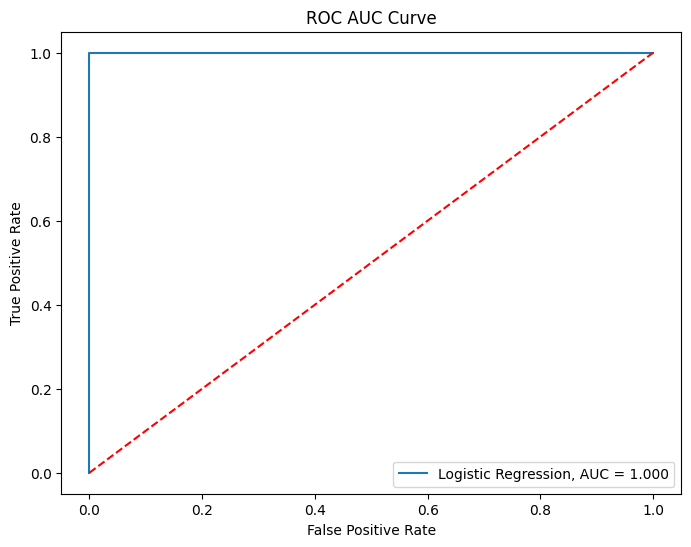

In [16]:
rocAucScore = roc_auc_score(yTrain, yPredicted)


falsePos, truePos, thresholds = roc_curve(yTrain, rfe.predict_proba(xTrain)[:, 1])


plt.figure(figsize=(8, 6)) 
plt.plot(falsePos, truePos, label=f'Logistic Regression, AUC = {rocAucScore:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.plot([0, 1], [0, 1], 'r--')  
plt.legend()
plt.show()

In [17]:
xTrainFiltered = trainData[columns]

xTrainFiltered = sm.add_constant(xTrainFiltered)
logit = sm.Logit(yTrain, xTrainFiltered)
try:
    logitModel = logit.fit()
    print(logitModel.summary())
except np.linalg.LinAlgError as e:
    print("Error:", e)
    print("Singular matrix error. Consider checking for multicollinearity or reducing the number of features.")


         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                   68
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            8
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:                   1.000
Time:                        20:00:08   Log-Likelihood:            -1.6121e-08
converged:                      False   LL-Null:                       -24.630
Covariance Type:            nonrobust   LLR p-value:                 5.667e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.2002   5.44e+08  -1.05e-07      1.000   -1.07e+09    1.07e+09
mean1         -6.3587   2.09e+07  -3.05e-07      1.000   -4.09e+0

## (a) v Test Classifier


In [18]:

testData = breakTimeSeriesForBinaryData(testCSVs, 1)
testData.dropna(inplace=True)  
xTest = testData.iloc[:, :-1]  
yTest = testData['Activity'] 

yPredicted = rfe.predict(xTest)


score = rfe.score(xTest, yTest)
print("Max Cross Validation Score is: ", score)


Max Cross Validation Score is:  1.0


## (a) vi Separation
### Yes, the distinct separation of classes within the model is highlighted by the inability of Maximum Likelihood optimization to converge, causing instability in the estimation of logistic regression parameters. Additionally, the p-values associated with all parameters are almost 1.

# (a) vii Imbalance

In [19]:
ros = RandomOverSampler(random_state=36)
xSampled, ySampled = ros.fit_resample(xTrain, yTrain)

logRegModel = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=5000)
rfe = RFE(estimator=logRegModel, n_features_to_select=8)
rfe.fit(xSampled, ySampled)

yPredicted = rfe.predict(xSampled)

confMatrix = confusion_matrix(ySampled, yPredicted)
print('The Confusion Matrix for Train data is:\n', confMatrix)

The Confusion Matrix for Train data is:
 [[60  0]
 [ 0 60]]


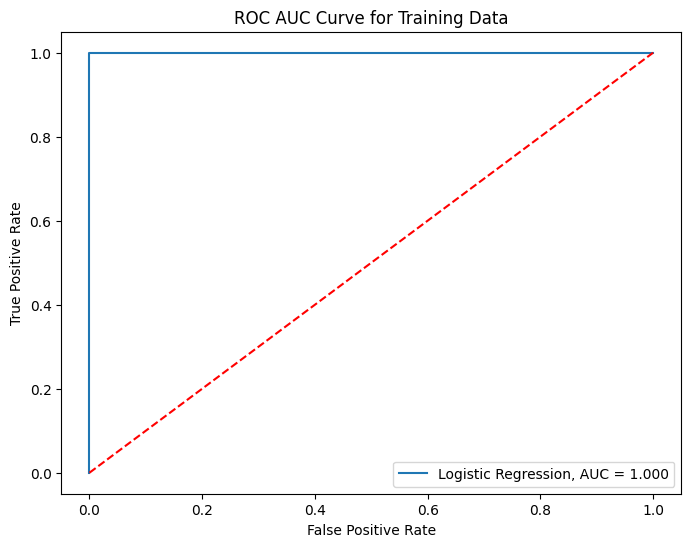

In [20]:
rocAucScore = roc_auc_score(ySampled, yPredicted)

falsePos, truePos, thresholds = roc_curve(ySampled, rfe.predict_proba(xSampled)[:, 1])

plt.figure(figsize=(8, 6))  
plt.plot(falsePos, truePos, label=f'Logistic Regression, AUC = {rocAucScore:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Training Data')
plt.plot([0, 1], [0, 1], 'r--')  
plt.legend(loc="lower right")
plt.show()


In [21]:
yPredicted_test = rfe.predict(xTest)

confMatrix_test = confusion_matrix(yTest, yPredicted_test)
print('The Confusion Matrix for test data is:\n', confMatrix_test)

The Confusion Matrix for test data is:
 [[15  0]
 [ 0  4]]


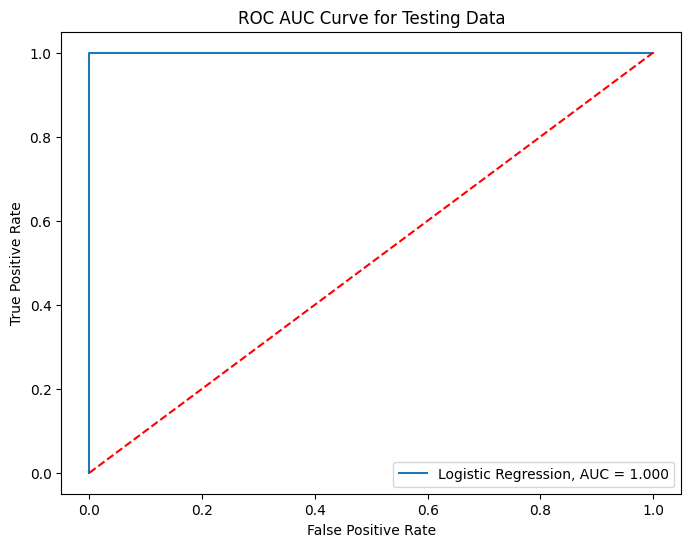

In [22]:
rocAucScore = roc_auc_score(yTest, yPredicted_test)

falsePos, truePos, thresholds = roc_curve(yTest, rfe.predict_proba(xTest)[:, 1])

plt.figure(figsize=(8, 6))  
plt.plot(falsePos, truePos, label=f'Logistic Regression, AUC = {rocAucScore:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Testing Data')
plt.plot([0, 1], [0, 1], 'r--')  
plt.legend(loc="lower right")
plt.show()

# (b) Binary Classification using L1-penalized logistic regression

## (b)i Time Series Segments

In [23]:
pFeats, scores = [], []
bestP, bestScore, bestL = None, 0, None

for i in range(1, 21):
    
    trainData = breakTimeSeriesForBinaryData(trainCSVs, i)
    trainData.dropna(inplace=True)
    xTrain = trainData.iloc[:, :-1]  
    yTrain = trainData['Activity']   
    stdScaler = StandardScaler()
    transXTrain = stdScaler.fit_transform(xTrain)

    param = {'C': np.linspace(1, 10, 10)}
    logRegModel = LogisticRegression(max_iter=5000)  
    cvModel = GridSearchCV(logRegModel, param, cv=5, scoring='accuracy')
    cvModel.fit(transXTrain, yTrain)

    select = SelectFromModel(LogisticRegression(C=cvModel.best_params_['C'], penalty='l1', solver='liblinear', max_iter=5000))
    select.fit(transXTrain, yTrain)
    selectedFeatures = xTrain.columns[select.get_support()]
    

    print(f'Value of l: {i}')
    print(f'Value of C: {cvModel.best_params_["C"]}')
    num_features = len(selectedFeatures)
    pFeats.append(num_features)
    score = cvModel.best_score_
    scores.append(score)
    print(f'Features Selected: {num_features}')
    print(f'Score: {score}\n')
    
    if score > bestScore:
        bestScore = score
        bestP = num_features
        bestL = i


print(f'Best number of segments (l): {bestL}, Best number of features (p): {bestP}, Best Score: {bestScore}')


Value of l: 1
Value of C: 1.0
Features Selected: 7
Score: 0.9142857142857143

Value of l: 2
Value of C: 1.0
Features Selected: 5
Score: 0.9131868131868132

Value of l: 3
Value of C: 1.0
Features Selected: 4
Score: 0.9131868131868132

Value of l: 4
Value of C: 1.0
Features Selected: 7
Score: 0.9131868131868132

Value of l: 5
Value of C: 1.0
Features Selected: 8
Score: 0.9131868131868132

Value of l: 6
Value of C: 2.0
Features Selected: 10
Score: 0.9274725274725275

Value of l: 7
Value of C: 1.0
Features Selected: 5
Score: 0.9274725274725275

Value of l: 8
Value of C: 1.0
Features Selected: 9
Score: 0.9263736263736264

Value of l: 9
Value of C: 1.0
Features Selected: 9
Score: 0.9274725274725275

Value of l: 10
Value of C: 1.0
Features Selected: 9
Score: 0.9274725274725275

Value of l: 11
Value of C: 1.0
Features Selected: 9
Score: 0.9263736263736264

Value of l: 12
Value of C: 1.0
Features Selected: 10
Score: 0.9120879120879122

Value of l: 13
Value of C: 1.0
Features Selected: 9
Score: 

In [24]:
print(f"The best value of l is {bestL}, and p is, {bestP}, and the accuracy is, {bestScore}")

The best value of l is 6, and p is, 10, and the accuracy is, 0.9274725274725275


## (b) ii.Comparison

### Both the approaches give more or less same number of features. However, the Recursive feature elimination process is difficult as compared to L1-penalized method. The L1- penalized cross validation took lesser time as compared to RFECV. According to me L1-penalized performed better on the time-series dataset.

# (c) Multi-Class Classification

## (c) i

In [25]:
def breakTimeSeriesForMulticlassData(filesList, n):
    
    finalColumns, finalData, l = [], [], []
    
    for csv in filesList:
        dataFrame = pd.read_csv(csv, skiprows = 4, on_bad_lines='skip')
        dataFrames = []
        split = 480 // n
        no = 0
        
        for frameNo in range(1, n + 1):
            colNames = ['avg_rss12_' + str(frameNo),'var_rss12_' + str(frameNo),'avg_rss13_' + str(frameNo),'var_rss13_' + str(frameNo),'avg_rss23_' + str(frameNo),'var_rss23_' + str(frameNo)]
            if frameNo == 1:
                dataFrame1 = dataFrame.iloc[:split, 1:]
            else:
                dataFrame1 = dataFrame.iloc[no: (frameNo * split), 1:]
                dataFrame1.reset_index(inplace = True, drop = True)
            dataFrame1.columns = colNames
            dataFrames.append(dataFrame1)
            no += split
        
        allFrames = pd.concat(dataFrames, axis = 1)
        filename = csv.split("/")
        
        desc = allFrames.describe().transpose().iloc[:, [1, 5, 2]]
        stats = []
            
        for i in range(6 * n):
            for j in range(3):
                s = desc.iloc[i, j]
                stats.append(s)
        
        stats.append(filename[-2])
        finalData.append(stats)
    
    for f in range(1, (n * 6) + 1):
        finalColumns.append('mean' + str(f))
        finalColumns.append('max' + str(f))
        finalColumns.append('std_dev' + str(f))
    finalColumns.append('Activity')
    
    requiredData = pd.DataFrame(finalData, columns = finalColumns)
    requiredData['Activity'] = requiredData['Activity'].map({'bending1': 1,'bending2': 2,'cycling': 3, 'lying': 4,'sitting': 5, 'standing': 6, 'walking': 7})
    return requiredData

In [26]:
pFeats, scores, l = [], [], []
bestP, bestScore, bestL, selectedFeats = None, 0, None, None

for i in range(1, 21):
    
    trainData = breakTimeSeriesForMulticlassData(trainCSVs, i)
    trainData.dropna(inplace=True)
    xTrain = trainData.iloc[:, :-1]
    yTrain = trainData['Activity']
    

    stdScaler = StandardScaler()
    transXTrain = stdScaler.fit_transform(xTrain)
    
    param = {'C': np.linspace(1, 10, 10)}
    cvModel = GridSearchCV(LogisticRegression(max_iter=5000), param, cv=5)
    cvModel.fit(transXTrain, yTrain)

    select = SelectFromModel(LogisticRegression(C=1 / cvModel.best_params_['C'], penalty='l1', solver='liblinear'))
    select.fit(transXTrain, yTrain)
    selectedFeatures = xTrain.columns[select.get_support()]
    

    pFeats.append(len(selectedFeatures))
    scores.append(cvModel.best_score_)
    l.append(i)
    

    print(f'Value of l: {i}')
    print(f'Value of C: {cvModel.best_params_["C"]}')
    print(f'Features Selected: {len(selectedFeatures)}')
    print(f'Score: {cvModel.best_score_}\n')
    
    if cvModel.best_score_ > bestScore:
        bestScore = cvModel.best_score_
        bestP = len(selectedFeatures)
        bestL = i
        selectedFeats = selectedFeatures.tolist()


print(f'Best l: {bestL}, Best p: {bestP}, Best Score: {bestScore}')
if selectedFeats is not None:
    print(f'Selected Features for Best Model: {selectedFeats}')


Value of l: 1
Value of C: 2.0
Features Selected: 12
Score: 0.9703296703296704

Value of l: 2
Value of C: 7.0
Features Selected: 17
Score: 0.9274725274725275

Value of l: 3
Value of C: 5.0
Features Selected: 23
Score: 0.8989010989010989

Value of l: 4
Value of C: 6.0
Features Selected: 24
Score: 0.8846153846153847

Value of l: 5
Value of C: 1.0
Features Selected: 42
Score: 0.8846153846153847

Value of l: 6
Value of C: 8.0
Features Selected: 20
Score: 0.9131868131868132

Value of l: 7
Value of C: 1.0
Features Selected: 58
Score: 0.8835164835164836

Value of l: 8
Value of C: 1.0
Features Selected: 57
Score: 0.8406593406593407

Value of l: 9
Value of C: 2.0
Features Selected: 53
Score: 0.8989010989010989

Value of l: 10
Value of C: 1.0
Features Selected: 61
Score: 0.8692307692307691

Value of l: 11
Value of C: 1.0
Features Selected: 63
Score: 0.8538461538461538

Value of l: 12
Value of C: 1.0
Features Selected: 68
Score: 0.8692307692307691

Value of l: 13
Value of C: 1.0
Features Selected:

In [27]:
print(f"The best value of l is {bestL}, and p is, {bestP}, and the accuracy is, {bestScore}")
print('The features that are selected by the model are:', selectedFeats)

The best value of l is 1, and p is, 12, and the accuracy is, 0.9703296703296704
The features that are selected by the model are: ['mean1', 'max1', 'std_dev1', 'max2', 'mean3', 'max3', 'std_dev3', 'std_dev4', 'mean5', 'max5', 'std_dev5', 'std_dev6']


In [28]:
trainData = breakTimeSeriesForMulticlassData(trainCSVs, 1)

trainData = trainData.dropna()

xTrain = trainData[selectedFeats]  
yTrain = trainData['Activity']

logRegModel = LogisticRegression()
logRegModel.fit(xTrain, yTrain)


LogisticRegression()

In [29]:
trainAccuracy = logRegModel.score(xTrain, yTrain)
print('The model accuracy for the training data is', trainAccuracy * 100, '%')

The model accuracy for the training data is 98.52941176470588 %


In [30]:
testData = breakTimeSeriesForMulticlassData(testCSVs, 1)

xTest = testData[selectedFeats]
yTest = testData['Activity']

testAccuracy = logRegModel.score(xTest, yTest)
print(f'The model accuracy for the testing data is {testAccuracy * 100:.2f}%')
print(f'The test error rate of the model is {(1 - testAccuracy) * 100:.2f}%')

yPredicted = logRegModel.predict(xTest)
yScores = logRegModel.decision_function(xTest) 
confMatrix = metrics.confusion_matrix(yTest, yPredicted)

print('\nThe confusion matrix is:\n')
print(confMatrix)


The model accuracy for the testing data is 89.47%
The test error rate of the model is 10.53%

The confusion matrix is:

[[2 0 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


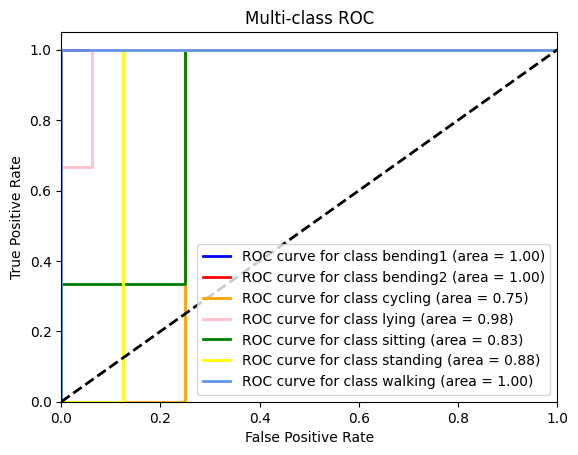

In [31]:
yTrain = label_binarize(yTrain, classes=[1, 2, 3, 4, 5, 6, 7])
yTest = label_binarize(yTest, classes=[1, 2, 3, 4, 5, 6, 7])
yPredicted = label_binarize(yPredicted, classes=[1, 2, 3, 4, 5, 6, 7])


classesN = yTrain.shape[1]
falsePosRate, truePosRate, rocAuc = dict(), dict(), dict()


for i in range(classesN):
    falsePosRate[i], truePosRate[i], _ = roc_curve(yTest[:, i], yScores[:, i])
    rocAuc[i] = auc(falsePosRate[i], truePosRate[i])


falsePosRate["micro"], truePosRate["micro"], _ = roc_curve(yTest.ravel(), yScores.ravel())
rocAuc["micro"] = auc(falsePosRate["micro"], truePosRate["micro"])


FPR = np.unique(np.concatenate([falsePosRate[i] for i in range(classesN)]))


meanTruePosRate = np.zeros_like(FPR)
for i in range(classesN):
    meanTruePosRate += interp(FPR, falsePosRate[i], truePosRate[i])


meanTruePosRate /= classesN
falsePosRate['macro'] = FPR
truePosRate['macro'] = meanTruePosRate
rocAuc['macro'] = auc(falsePosRate['macro'], truePosRate['macro'])

plt.figure()
colors = cycle(['blue', 'red', 'orange', 'pink', 'green', 'yellow', 'cornflowerblue'])
classes = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']

for i, color in zip(range(classesN), colors):
    plt.plot(falsePosRate[i], truePosRate[i], color=color, lw=2,
             label=f'ROC curve for class {classes[i]} (area = {rocAuc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

## (c) ii. Naive Bayes

In [32]:
bestGaus, bestL = 0, None

for i in range(1, 21):
    trainData = breakTimeSeriesForMulticlassData(trainCSVs, i)
    trainData.dropna(inplace=True)  
    xTrain = trainData.iloc[:, :-1]  
    yTrain = trainData['Activity']  

    testData = breakTimeSeriesForMulticlassData(testCSVs, i)
    xTest = testData.iloc[:, :-1]  
    yTest = testData['Activity']  


    gaussianNB = GaussianNB()
    gausModel = gaussianNB.fit(xTrain, yTrain)
    

    score = gausModel.score(xTest, yTest)
    print(f'Split {i}: Accuracy = {score:.4f}')
    
 
    if score > bestGaus:
        bestGaus = score
        bestL = i

print(f'\nThe best split is when value of l is {bestL} and the best testing score is {bestGaus:.4f}')

Split 1: Accuracy = 0.7895
Split 2: Accuracy = 0.6842
Split 3: Accuracy = 0.7368
Split 4: Accuracy = 0.7368
Split 5: Accuracy = 0.7368
Split 6: Accuracy = 0.7895
Split 7: Accuracy = 0.6842
Split 8: Accuracy = 0.7368
Split 9: Accuracy = 0.6842
Split 10: Accuracy = 0.6842
Split 11: Accuracy = 0.6842
Split 12: Accuracy = 0.6316
Split 13: Accuracy = 0.6842
Split 14: Accuracy = 0.7368
Split 15: Accuracy = 0.7368
Split 16: Accuracy = 0.7368
Split 17: Accuracy = 0.6316
Split 18: Accuracy = 0.6842
Split 19: Accuracy = 0.6842
Split 20: Accuracy = 0.7368

The best split is when value of l is 1 and the best testing score is 0.7895


### The best testing accuracy of Multinomial Naive Bayes is 0.8947

### The best testing accuracy of Gaussian Naive Bayes is 0.7894

# (C) iii


### The best testing accuracy of Multiclass Logistic Regression is also around 0.8947. Hence, Multiclass logistic regression and Multinomial NB perform better than Gaussian NB.

# ISLR 4.8.3

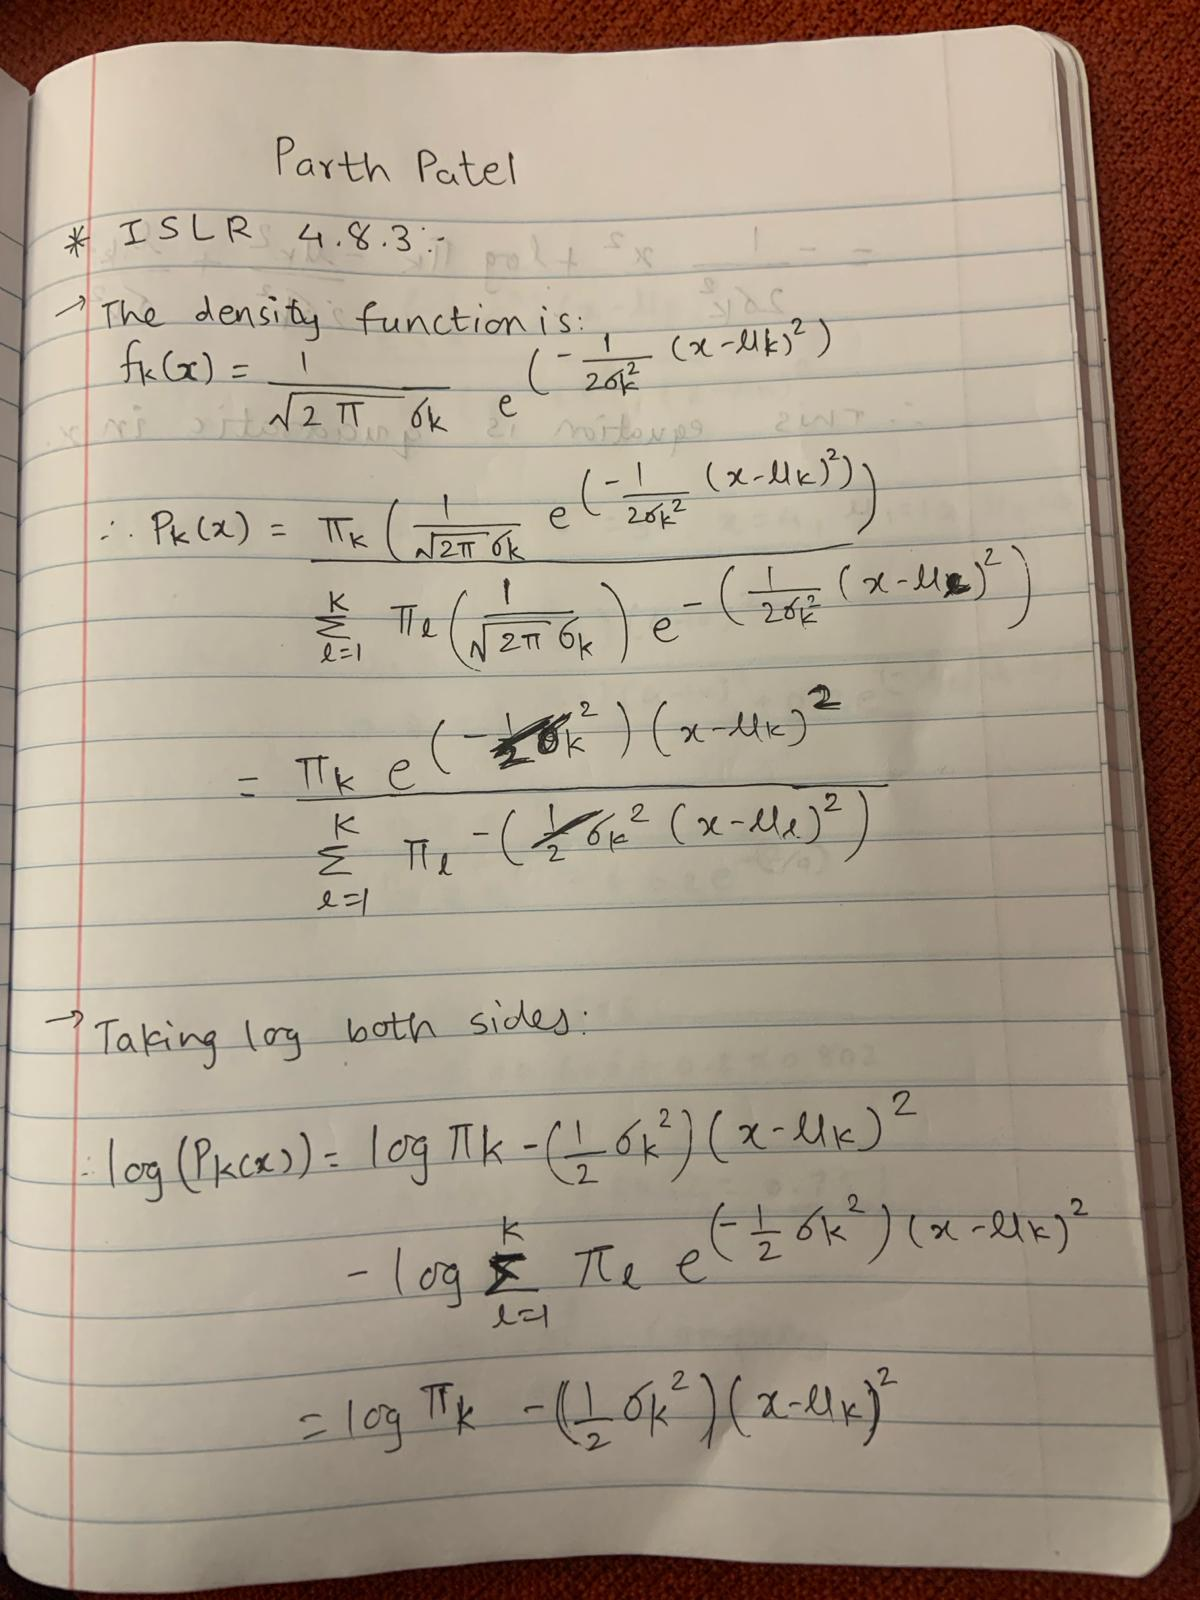

In [33]:
from IPython.display import Image
Image(filename='ISLR4.8.3(1).jpeg')

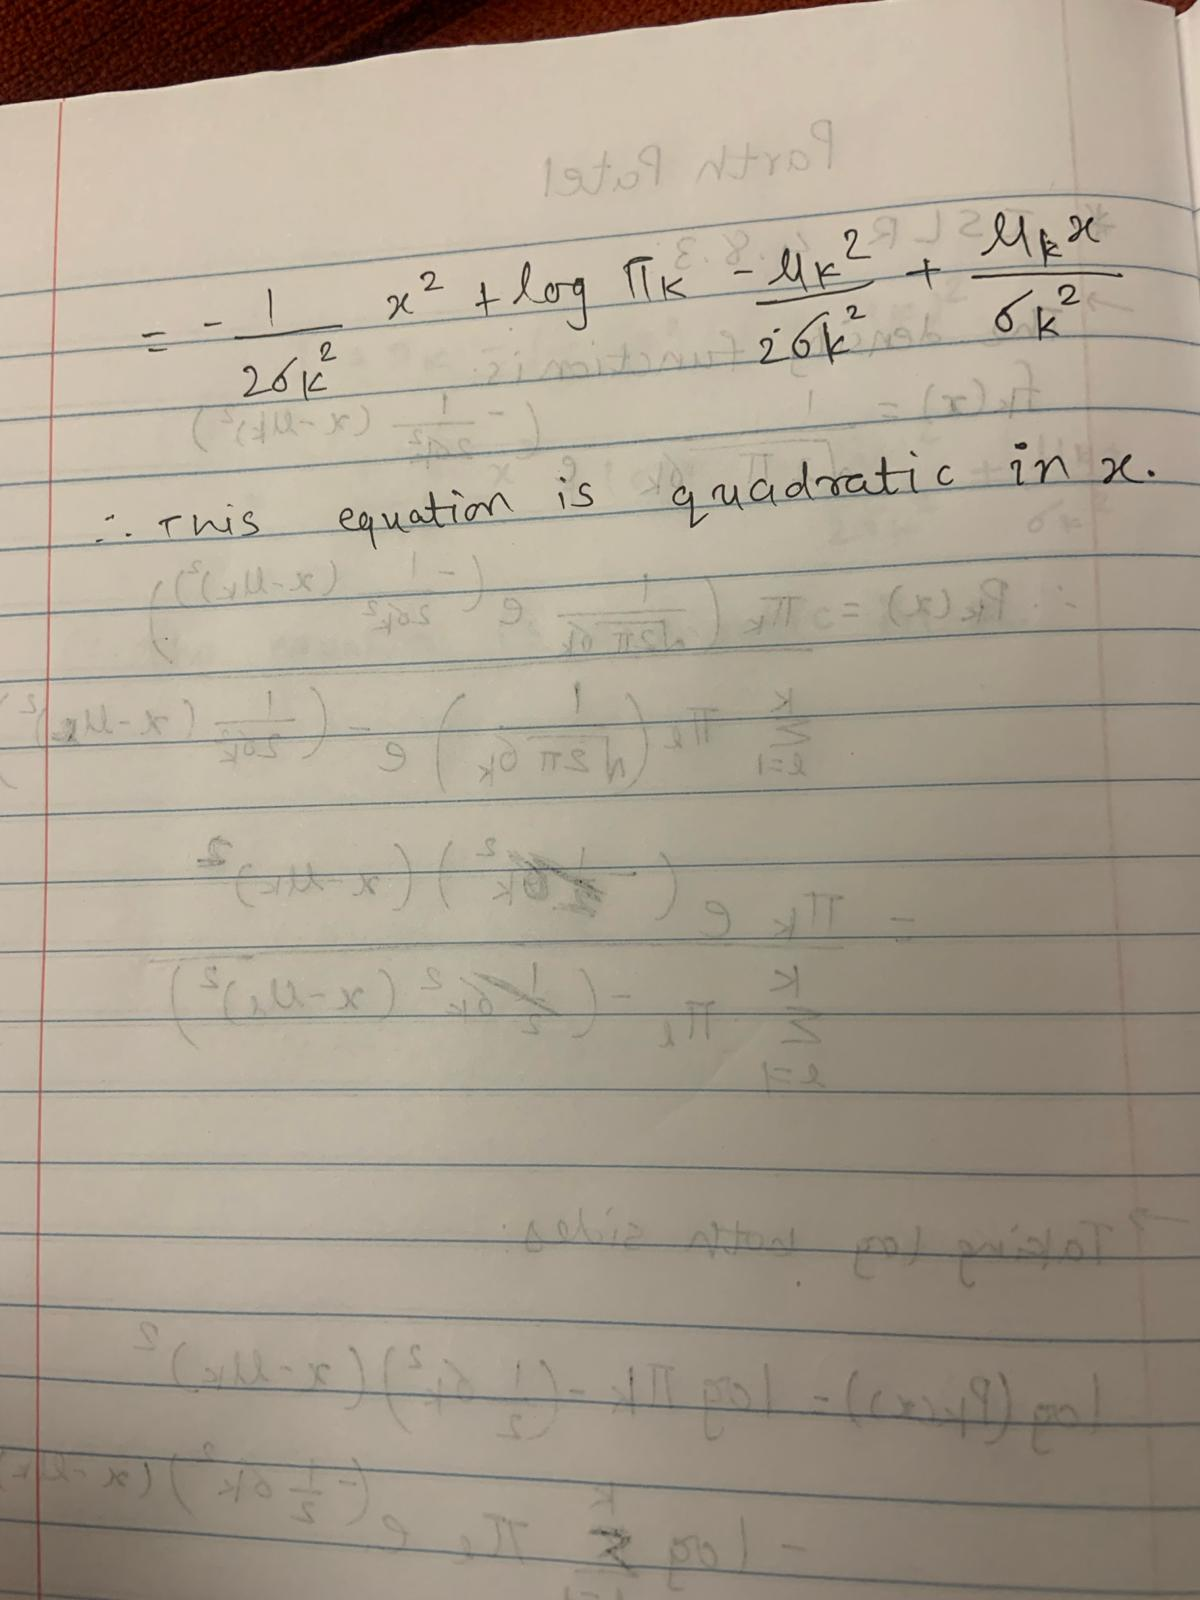

In [34]:
Image(filename='ISLR4.8.3(2).jpeg')

# ISLR 4.8.7

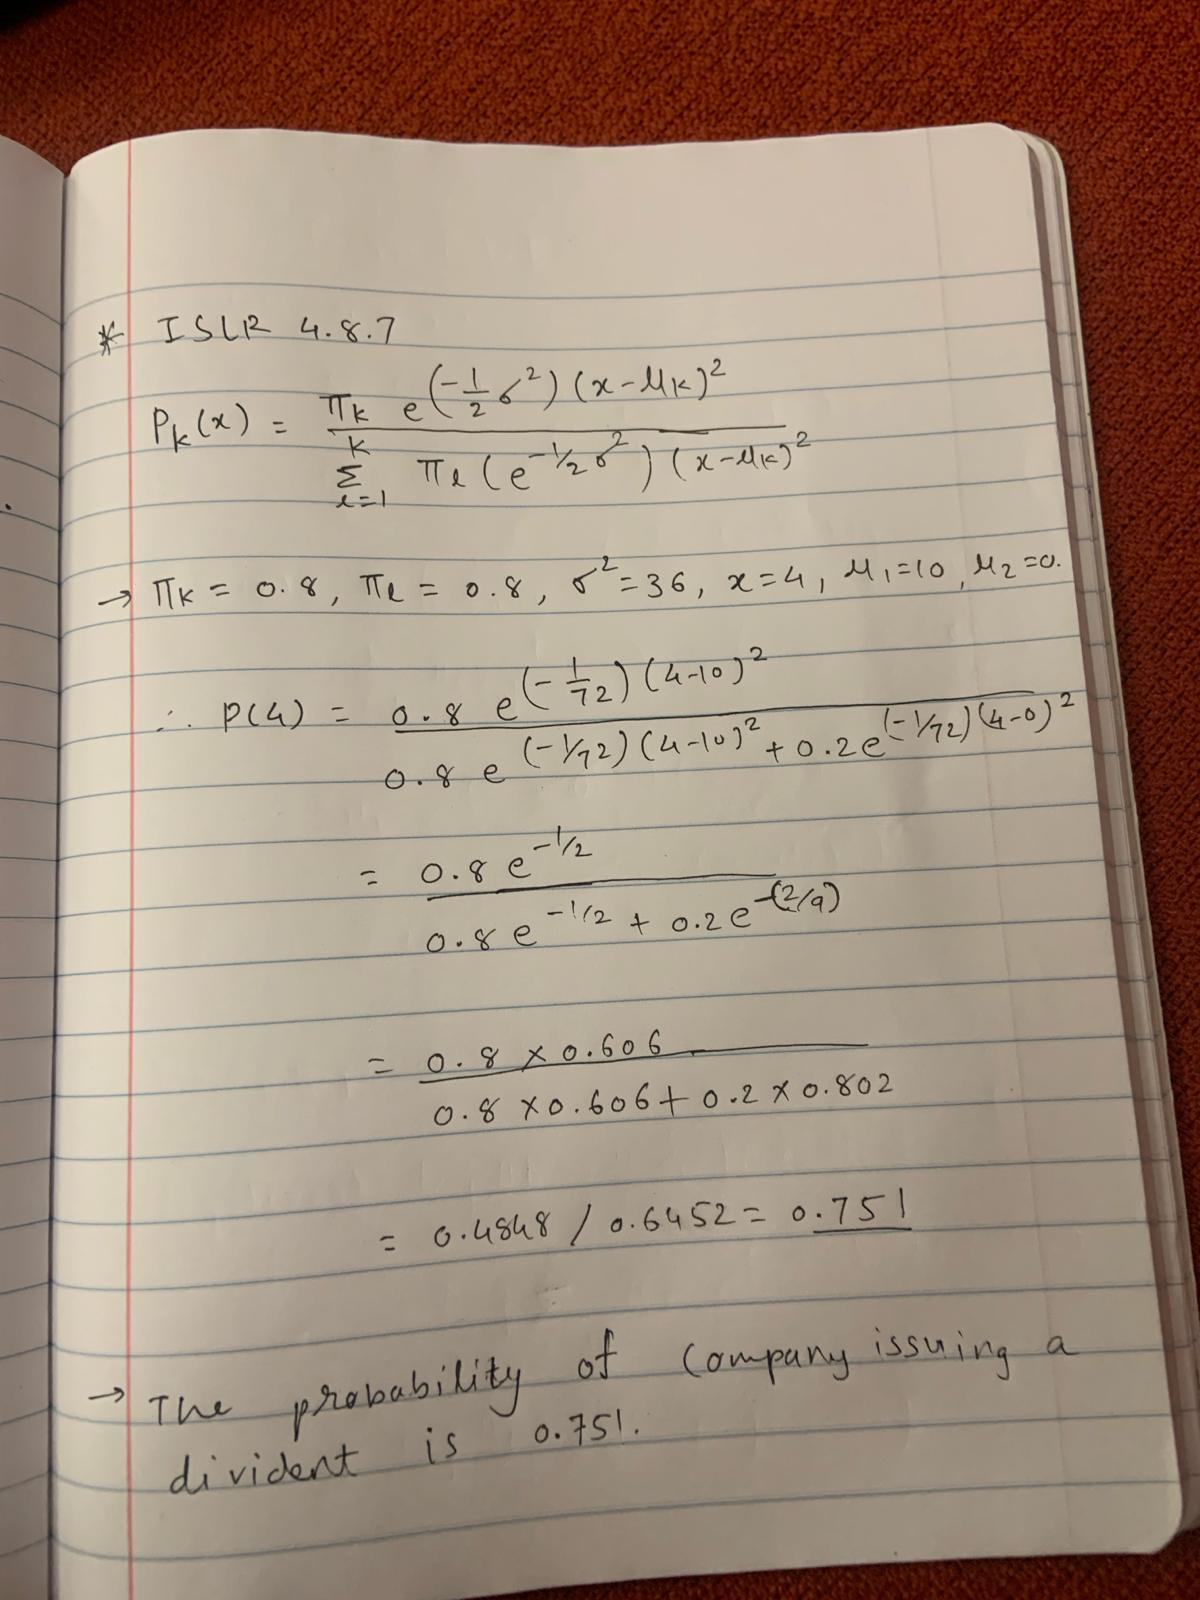

In [35]:
Image(filename='ISLR4.8.7.jpeg')

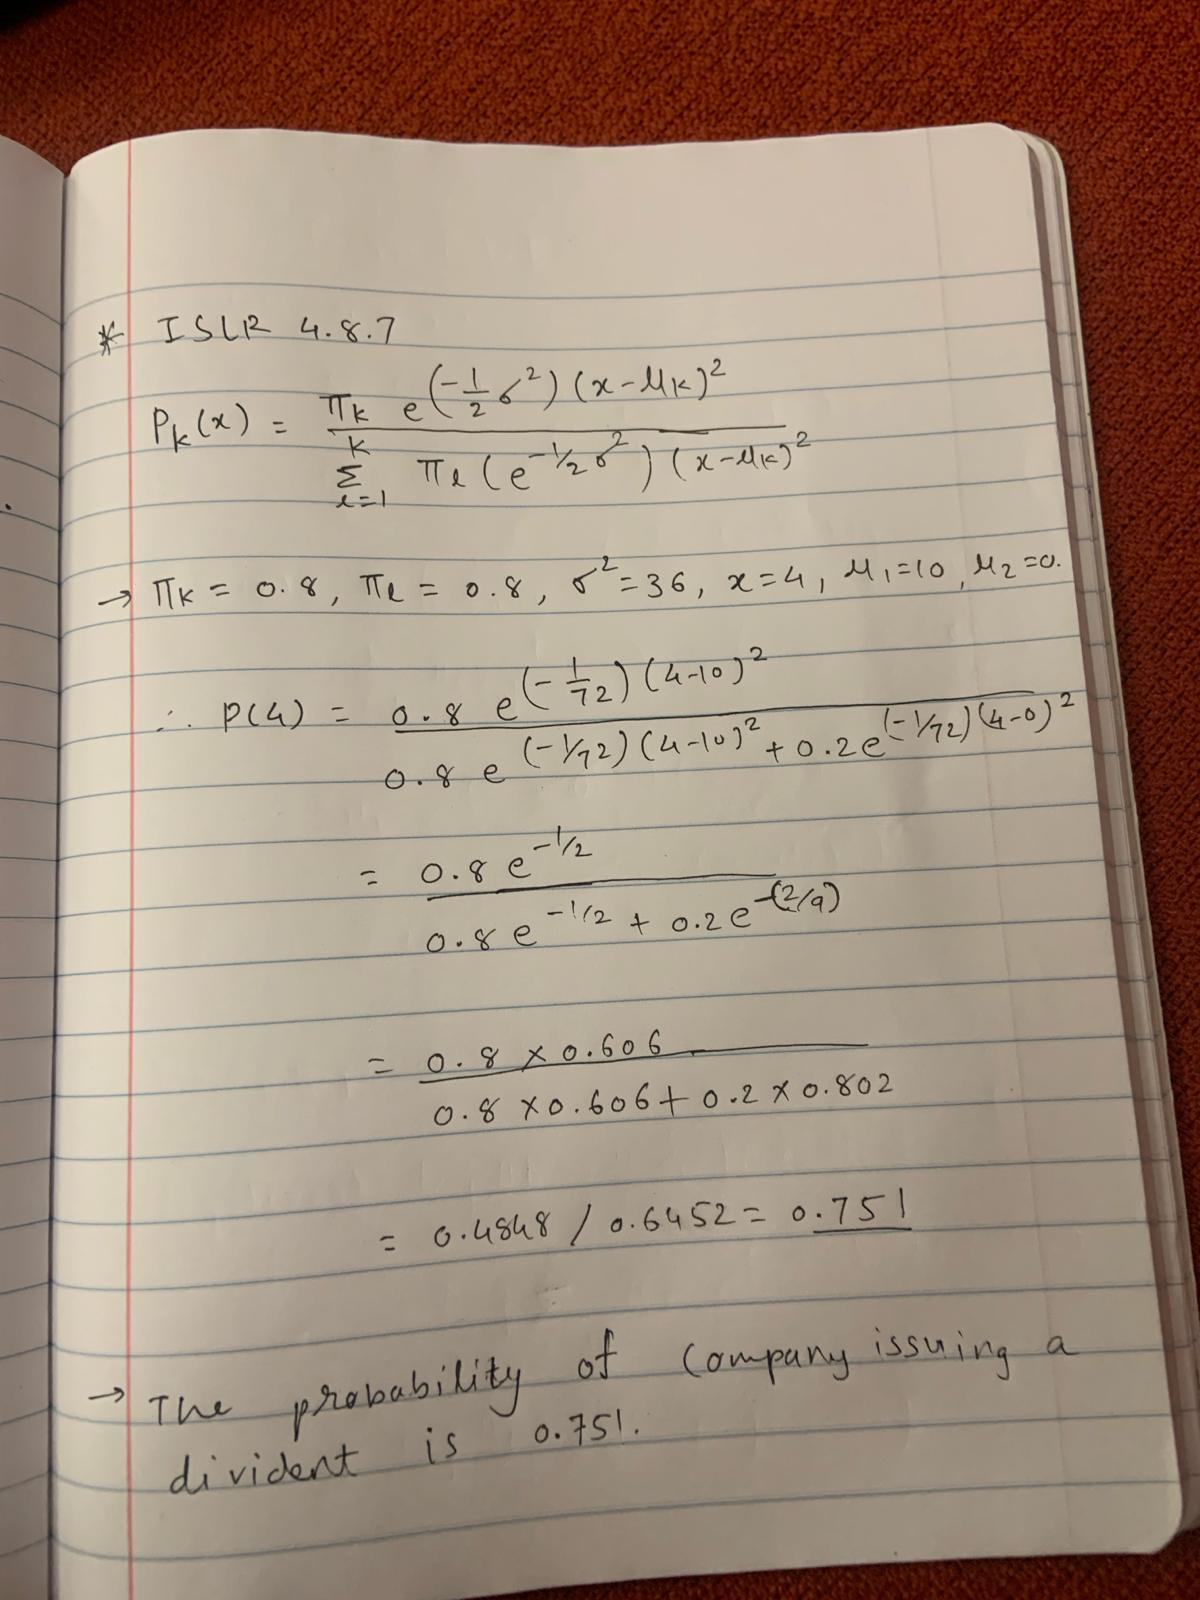